<a href="https://colab.research.google.com/github/cjweems/image-filter-project/blob/feedback/Image_Filter_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IPython.core.display.Javascript object>

Saved to photo.jpg


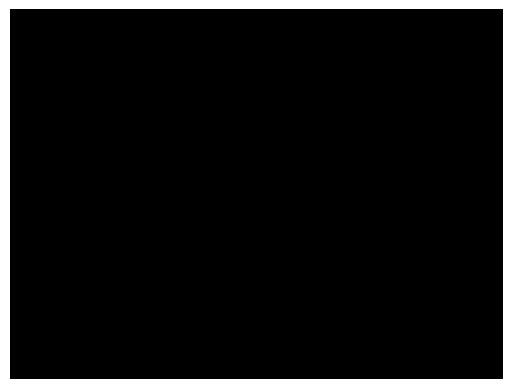

In [55]:
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not grant the page permission to access it.
  print(str(err))

# Read the image
img = cv2.imread('photo.jpg')

# Conver the image to grayscale
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Load the pre-trained classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Note the change

# Preform the face detection
face = face_cascade.detectMultiScale(gray_img,1.1,4)

# # Draw a circle around the face
# for x,y,width,height in face:
#   # Finds the center of the face
#   corner1 = (x,y)
#   corner2 = (x+width, y)
#   corner3 = (x, y+height)
#   corner4 = (x+width, y+height)
#   centerx = (x + (x+width) + x + (x+width)) / 4
#   centery = (y + (y+height) + y + (y+height)) / 4

#   # Calculates the radius from the center point
#   rad = abs(y - centery)

#   # Draws the circle
#   cv2.circle(img, (int(centerx),int(centery)), radius = int(rad), color = (0,255,0), thickness =1)

# # Displays the image
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)
# plt.axis('on')

#Draw an ellipse that is more accurate to the face shape
for x,y,width,height in face:
  # Find the center of the face
  corner1 = (x,y)
  corner2 = (x+width, y)
  corner3 = (x, y+height)
  corner4 = (x+width, y+height)
  centerx = (x + (x+width) + x + (x+width)) / 4
  centery = (y + (y+height) + y + (y+height)) / 4

  # Draw the ellipse to fit the face
  center_coordinates = (int(centerx), int(centery))
  axesLength = (125, 175) # How can this be adaptive?
  cv2.ellipse(img, center_coordinates, axesLength, 0, 0, 360, (0, 0, 255), 1)

# Display the image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')

# # Face region
# bx, by, w, h = x, y, width, height

# # Extract the face region
# faceRegion = img_rgb[by:by+h, bx:bx+w]

# # Blur everything else
# blurredBackground = cv2.blur(img_rgb, (10, 10))

# # Put the normal face on the blurred background
# blurredBackground[by:by+h, bx:bx+w] = faceRegion

# # Display the image
# plt.imshow(blurredBackground)

# Create a mask with the same size as the image
mask = np.zeros_like(img)

# Draw the ellipse on the mask
cv2.ellipse(img, center_coordinates, axesLength, 0, 0, 360, (255, 255, 255), -1)

# Bitwise AND operation to extract the oval-shaped region
result = cv2.bitwise_and(img, mask)

plt.imshow(result)